# 호모그래피

![img](https://t1.daumcdn.net/cfile/tistory/22638F4E578A0BB114)

+ 3차원 공간상의 평면을 서로 다른 시점에서 바라봤을 때 획득되는 영상 사이의 관계를 나타내는 용어

+ 호모그래피를 사용하면 크기가 다르고 회전이 되어 있는 객체를 정확하게 매칭할 수 있음

OpenCV에서는 findHomography()를 사용하여 추출된 특징점 매칭 정보로부터 호모그래피를 연산할 수 있음.

## findHomography(src,dst,method,confidence)

+ src - 원본 이미지
+ dst - 목표 이미지

+ 호모그래피 행렬 계산 방법을 설정함.

    + 0 - 최소자승법(모든 점을 사용함)
    + LMEDS - 최소 메디안 제곱,mask 인자 필요
    + RANSAC - RANSAC 방법, ransacReprojThreshold,maxlters,mask 인자 설정 필요
    + RHO - PROSAC 방법, ransacReprojThreshold 인자 설정 필요   
   
    
    
+ confidence - 신뢰도 레벨 0~1 실수 지정

+ ransacReprojThreshold - 최대 허용 재투영 에러
+ mask - 호모그래피 계산에 사용된 점들을 알려주는 출력 마스크 행렬
+ maxlters - RANSAC 반복 횟수

출력으로는 3*3 호모그래피 행렬을 반환함


In [27]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

#찾을 이미지 그레이스케일 이미지 사용
src = cv2.imread('./img/matcher/goal.PNG',cv2.IMREAD_GRAYSCALE)

#찾을 대상 이미지 그레이스케일 이미지 사용
dst = cv2.imread('./img/matcher/target.jpg',cv2.IMREAD_GRAYSCALE)

In [28]:
#SIFT로 특징점을 검출함
detector = cv2.SIFT_create()

#특징점 검출
kp1,desc1 = detector.detectAndCompute(src,None)
kp2,desc2 = detector.detectAndCompute(dst,None)

In [29]:
#FLANN - KNN으로 매칭
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)


matcher = cv2.FlannBasedMatcher(index_params,search_params)
matches = matcher.knnMatch(desc1,desc2,k=2)

good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)

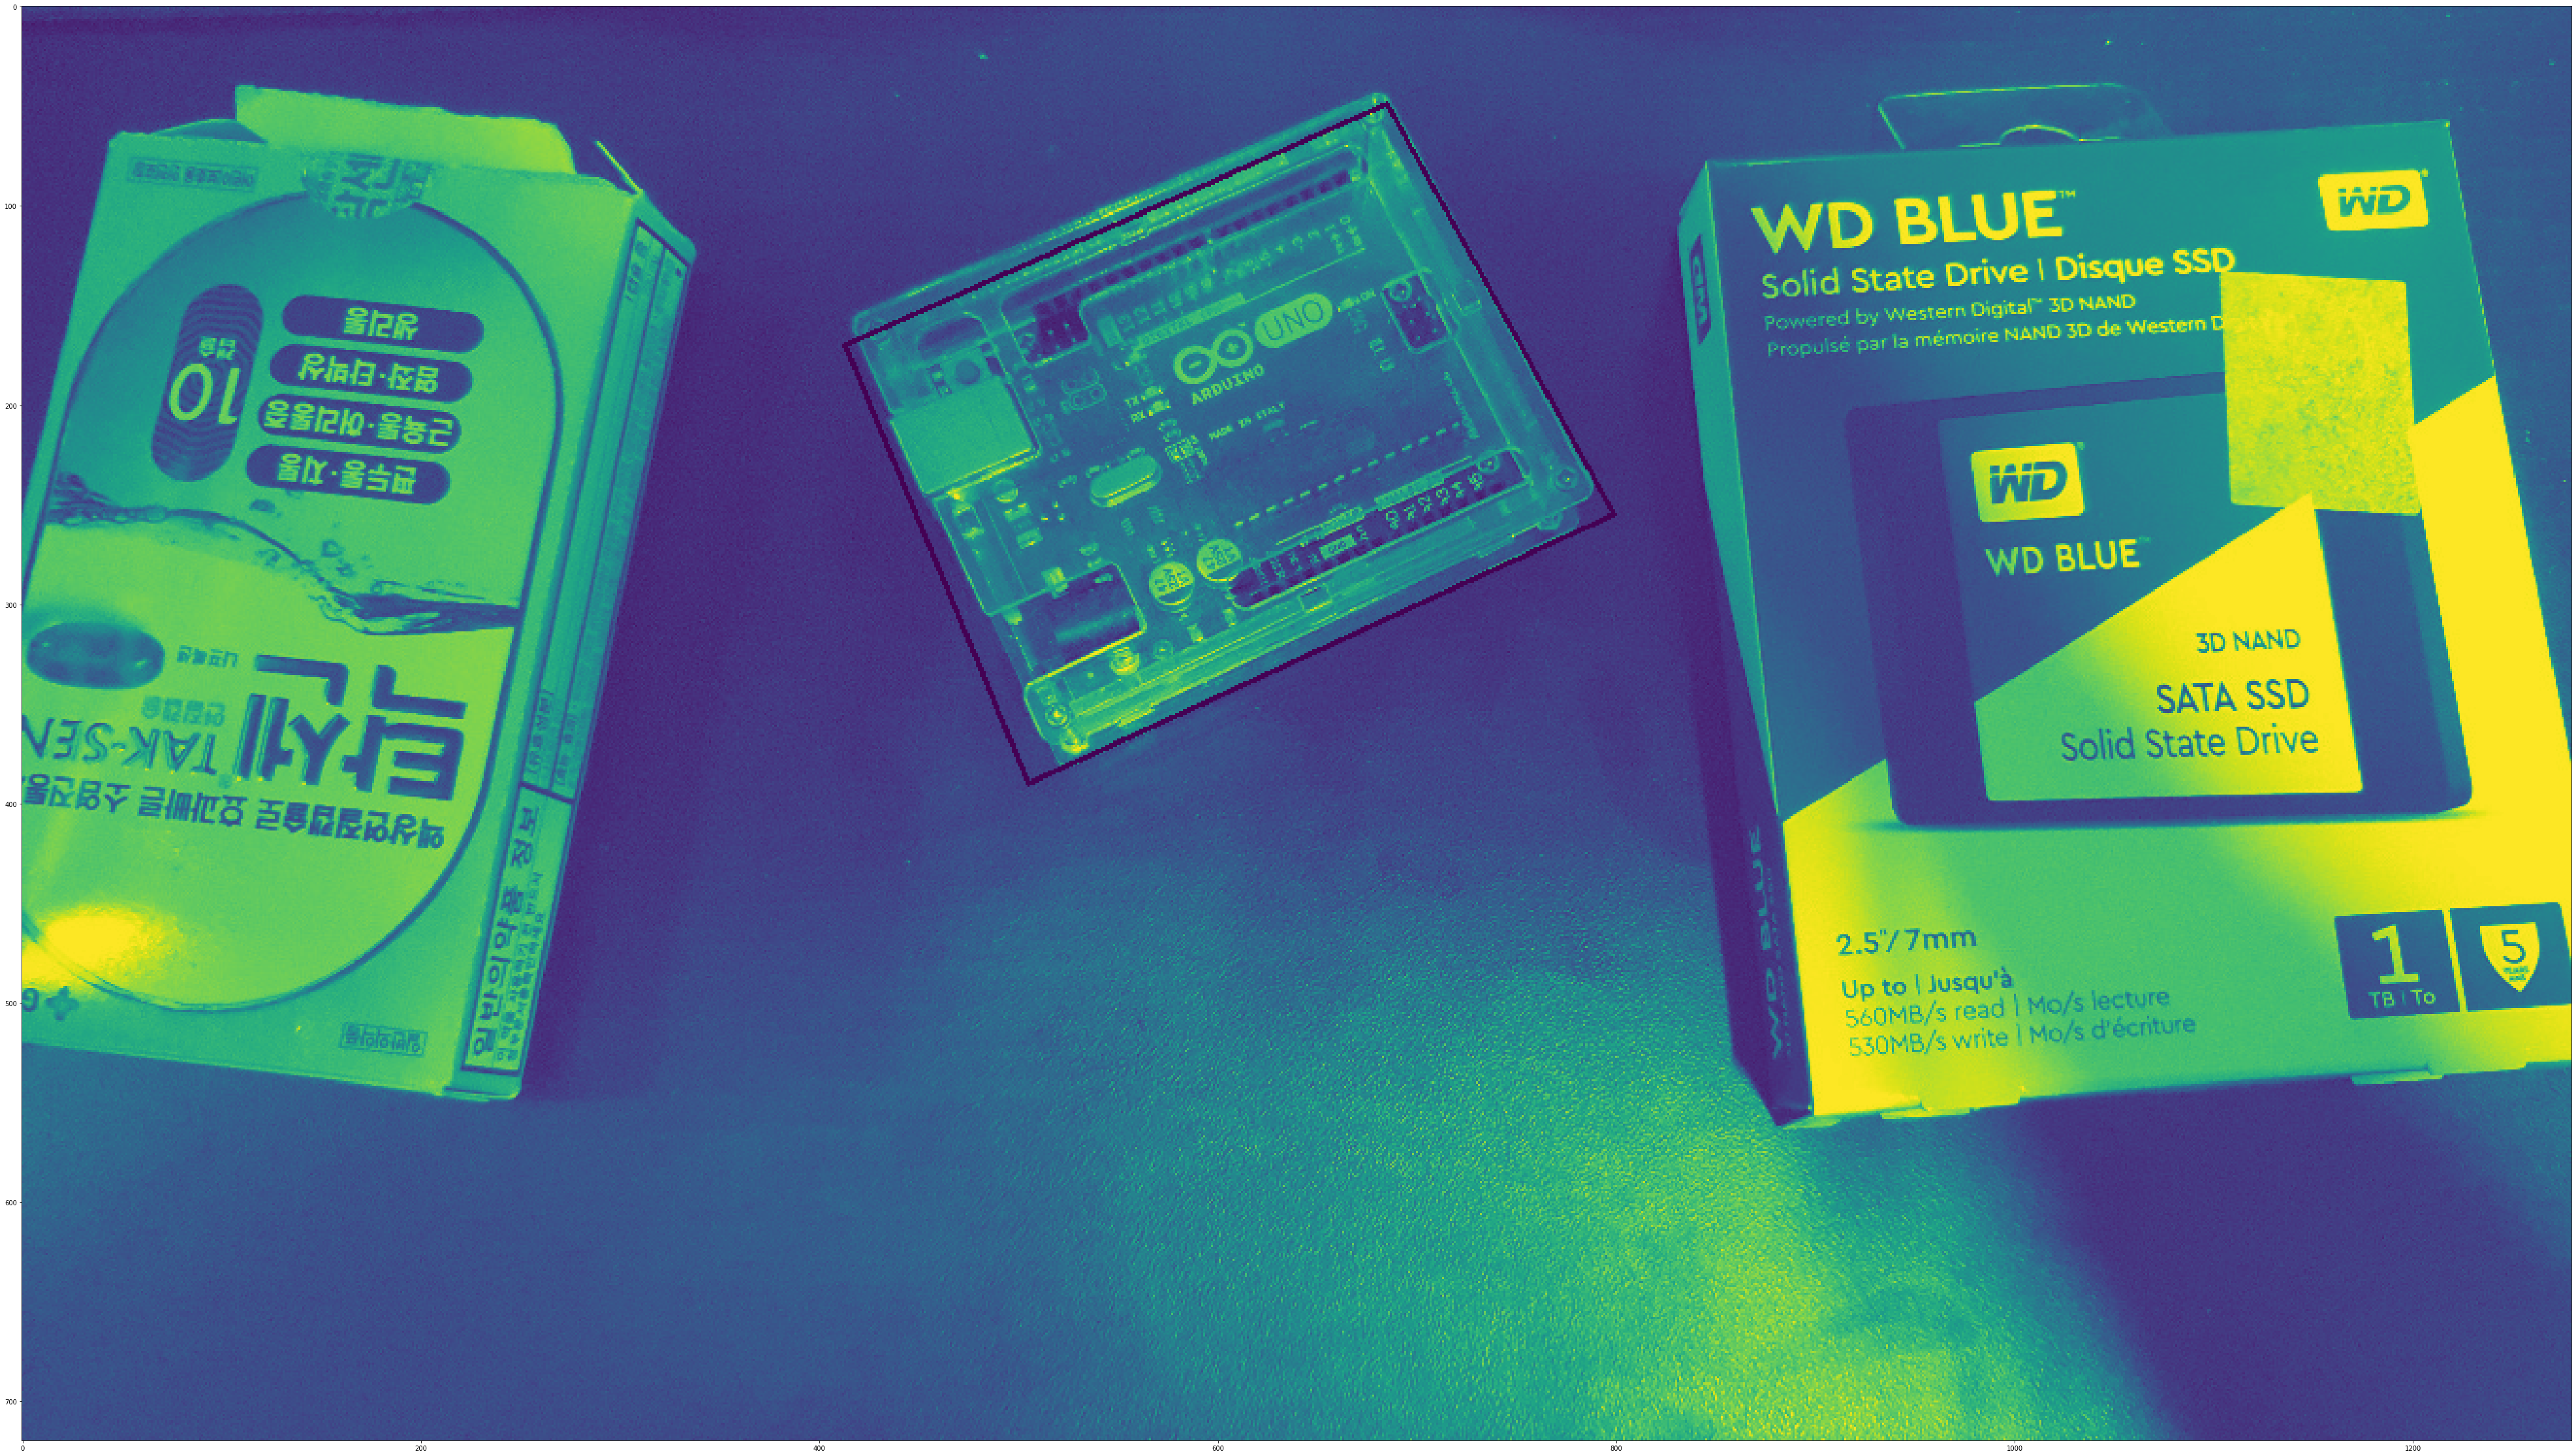

In [30]:
#주요 키포인트들을 찾아줌
src_pts = np.float32([ kp1[i.queryIdx].pt for i in good ]).reshape(-1,1,2) 
dst_pts = np.float32([ kp2[i.trainIdx].pt for i in good ]).reshape(-1,1,2) 

#호모그래피로 변환 행렬을 구함.
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0) 
matches_Mask = mask.ravel().tolist() 
#src 이미지 들의 코너들을 원근 변환 행렬로 dst 이미지 위에 그림.
#이후 선을 그려주면 사각형이 만들어짐.

h,w = src.shape 
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2) 

transcform_img = cv2.perspectiveTransform(pts,M) 
dst = cv2.polylines(dst,[np.int32(transcform_img)],True,(0,255,0),2)

plt.figure(figsize=(70,70))
plt.imshow(dst)



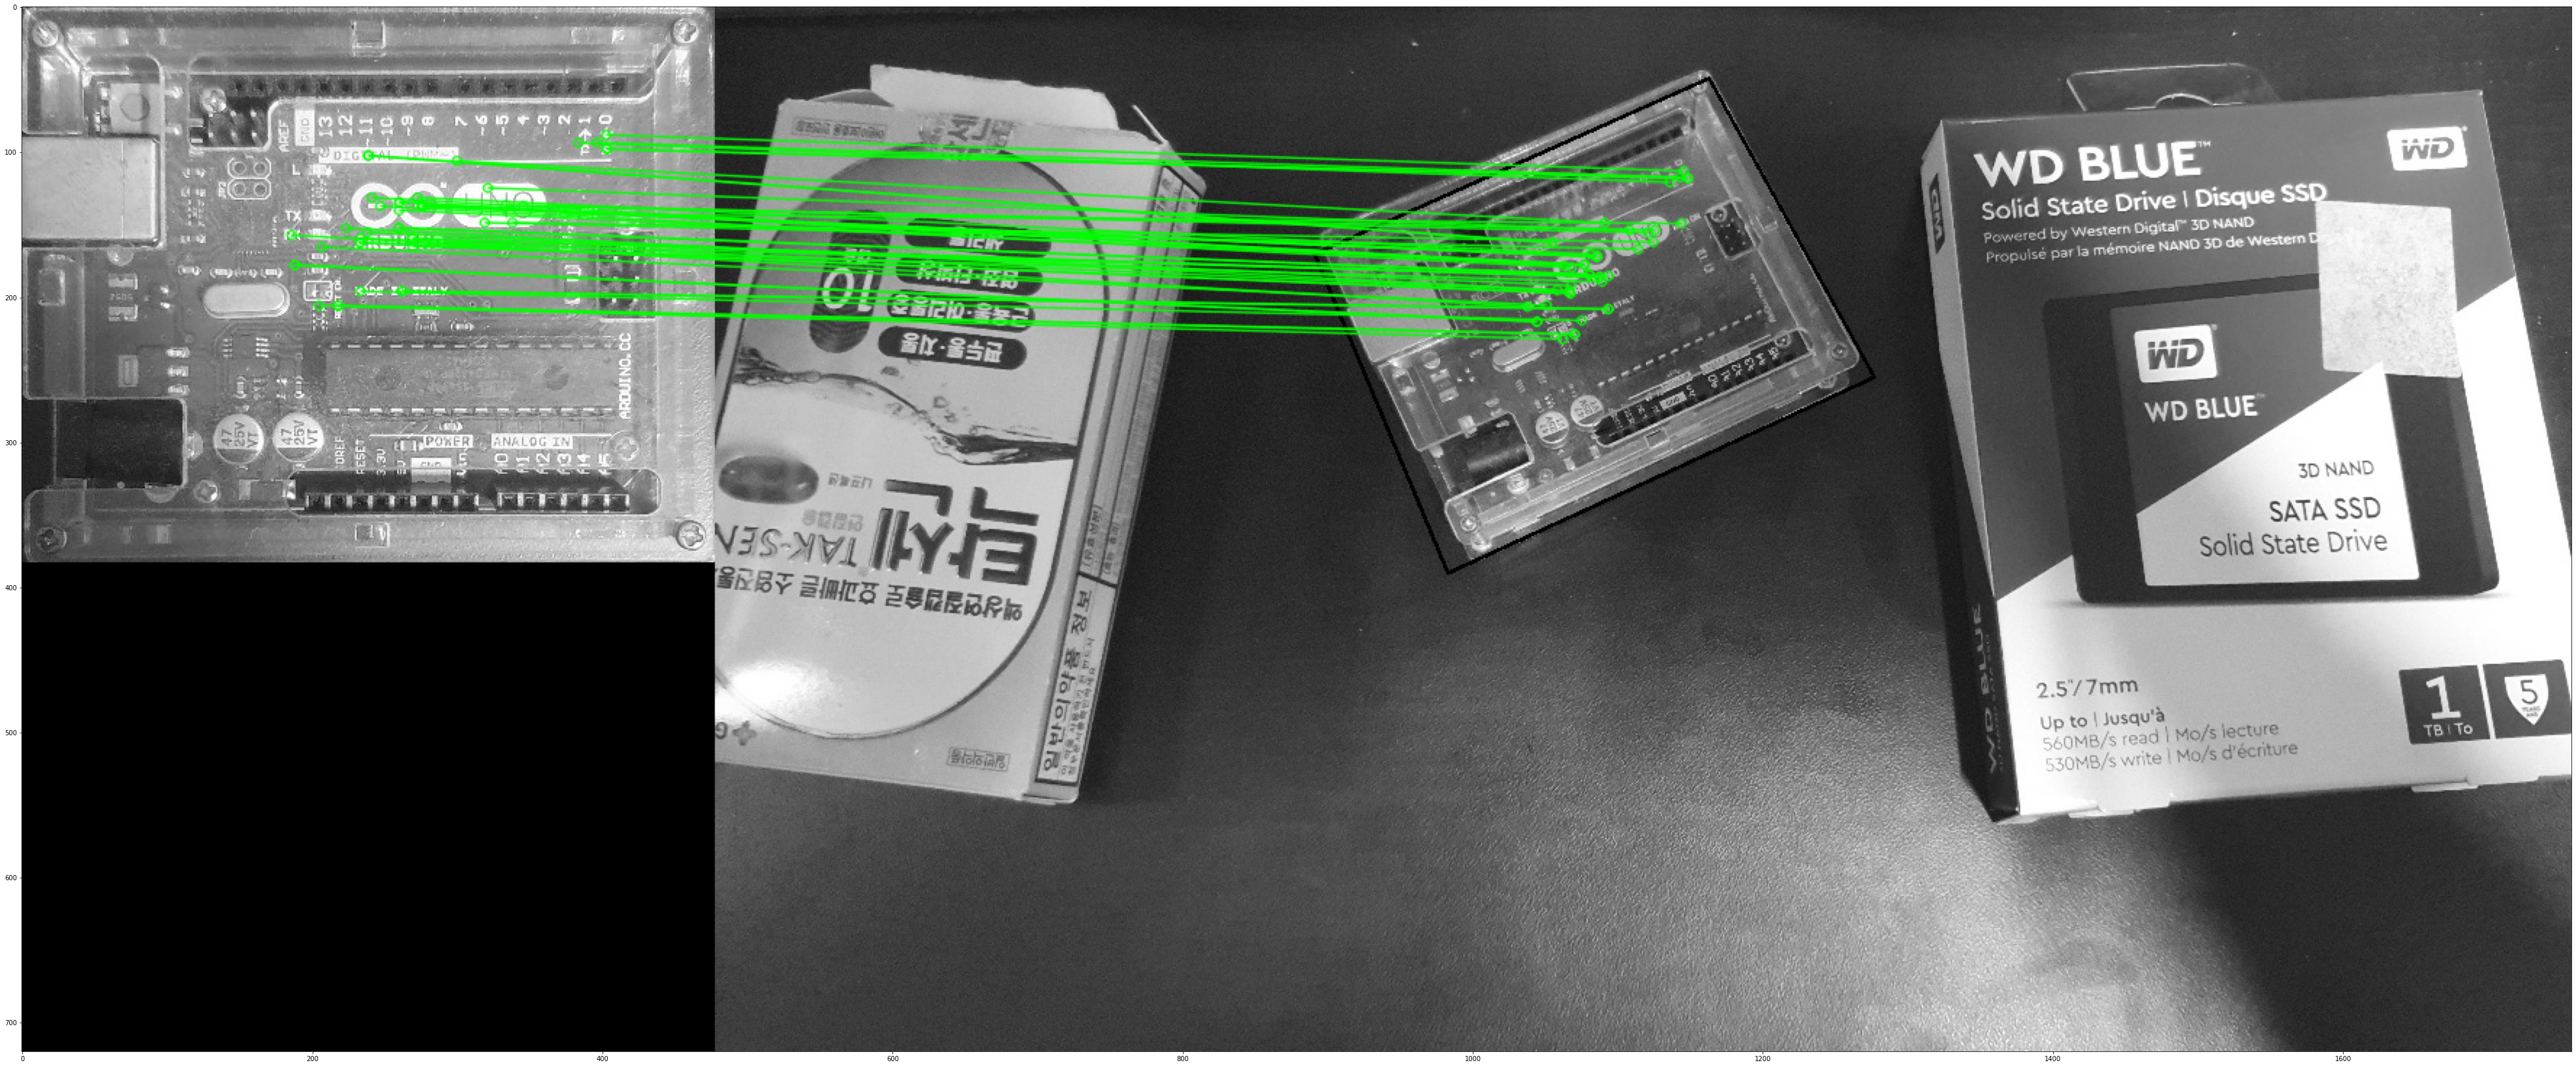

In [33]:
draw_params = dict(matchColor = (0,255,0), singlePointColor = None, matchesMask = matches_Mask, flags = 2) 
fin = cv2.drawMatches(src,kp1,dst,kp2,good,None,**draw_params)

plt.figure(figsize=(70,70))
plt.imshow(fin)
